## Microsoft Malware Prediction

The goal of this competition is to predict a Windows machine’s probability of getting infected by various families of malware, based on different properties of that machine. It is really important to find out whether the computer is infected and cure it.

We have a huge dataset of data, where most features are categorical. I think that correct mean encoding should be important. Also the number of columns is quite high so it could be tempting to make some automatical processing for all columns. I personally think that it is important to analyze each variable and it could help to do a better processing.

In this kernel I'll do a detailed EDA, feature engineering and modelling.

![](https://storage.googleapis.com/kaggle-competitions/kaggle/10683/logos/thumb76_76.png?t=2018-09-19-16-55-15)

In [1]:
#libraries
import numpy as np 
import pandas as pd 
import os
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import lightgbm as lgb
import xgboost as xgb
import time
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import gc
from catboost import CatBoostClassifier
from tqdm import tqdm_notebook
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings("ignore")

import logging

logging.basicConfig(filename='log.txt',level=logging.DEBUG, format='%(asctime)s %(message)s')

pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 100)
import os
print(os.listdir("../input/"))


['test.csv', 'train.csv', 'sample_submission.csv']


## Loading data
Let's try loading data in a naive way

In [2]:
#https://www.kaggle.com/theoviel/load-the-totality-of-the-data
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = [c for c,v in dtypes.items() if v in numerics]
categorical_columns = [c for c,v in dtypes.items() if v not in numerics]

In [4]:
%%time
train = pd.read_csv('../input/train.csv', dtype=dtypes)

CPU times: user 2min 36s, sys: 12.8 s, total: 2min 48s
Wall time: 2min 49s


In [5]:
train = reduce_mem_usage(train)

Mem. usage decreased to 2363.03 Mb (0.0% reduction)


In [6]:
stats = []
for col in train.columns:
    stats.append((col, train[col].nunique(), train[col].isnull().sum() * 100 / train.shape[0], train[col].value_counts(normalize=True, dropna=False).values[0] * 100, train[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
28,PuaMode,2,99.974119,99.974119,category
41,Census_ProcessorClass,3,99.589407,99.589407,category
8,DefaultBrowsersIdentifier,1730,95.141637,95.141637,float16
68,Census_IsFlightingInternal,2,83.044030,83.044030,float16
52,Census_InternalBatteryType,78,71.046809,71.046809,category
71,Census_ThresholdOptIn,2,63.524472,63.524472,float16
75,Census_IsWIMBootEnabled,2,63.439038,63.439038,float16
31,SmartScreen,21,35.610795,48.379658,category
15,OrganizationIdentifier,49,30.841487,47.037662,float16
29,SMode,2,6.027686,93.928812,float16


We can see several interesting things here:
* PuaMode and Census_ProcessorClass have 99%+ missing values, which means that these columns are useless and should be dropped;
* In DefaultBrowsersIdentifier column 95% values belong to one category, so I think this columns is also useless;
* Census_IsFlightingInternal is strange, but maybe analysis of it will make sense;
* There are 26 columns in total in which one category contains 90% values. I think that these imbalanced columns should be removed from the dataset;
* One more important point is that there are many columns which are considered to be numerical (from this kernel: #https://www.kaggle.com/theoviel/load-the-totality-of-the-data), but I think they are categorical - like CityIdentifier. We'll see more in EDA below;


I see that all columns except Census_SystemVolumeTotalCapacity are categorical. 
Also there are 3 columns, where most of the values are missing. Let's drop them.

In [7]:
good_cols = list(train.columns)
for col in train.columns:
    rate = train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        good_cols.remove(col)

In [8]:
train = train[good_cols]

Now we can read test data.

In [9]:
test_dtypes = {k: v for k, v in dtypes.items() if k in good_cols}
test = pd.read_csv('../input/test.csv', dtype=test_dtypes, usecols=good_cols[:-1])
test.loc[6529507, 'OsBuildLab'] = '17134.1.amd64fre.rs4_release.180410-1804'
test['OsBuildLab'] = test['OsBuildLab'].fillna('17134.1.amd64fre.rs4_release.180410-1804')
test = reduce_mem_usage(test)

Mem. usage decreased to 1826.49 Mb (0.0% reduction)


## Data exploration

In [10]:
train.head()

,MachineIdentifier,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,1.1.15100.1,4.18.1807.18075,1.273.1735.0,53447.0,1.0,29,128035.0,18.0,35.0,-85,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,NaN,Desktop,2668.0,9124.0,4.0,5.0,2340.0,476940.0,HDD,299451.0,4096.0,Desktop,18.906250,1440.0,900.0,Desktop,NaN,4.294967e+09,10.0.17134.165,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,26.0,119,UNKNOWN,IS_GENUINE,Retail,NaN,NaN,628.0,36144.0,0,NaN,0,0.0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,1.1.14600.4,4.13.17134.1,1.263.48.0,53447.0,1.0,93,1482.0,18.0,119.0,64,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,NaN,Notebook,2668.0,91656.0,4.0,5.0,2404.0,476940.0,HDD,102385.0,4096.0,Notebook,13.898438,1366.0,768.0,Mobile,NaN,1.000000e+00,10.0.17134.1,rs4_release,17134,1,Professional,PROFESSIONAL,IBSClean,8.0,31,UNKNOWN,OFFLINE,Retail,NaN,NaN,628.0,57858.0,0,NaN,0,0.0,8.0,0
2,000007905a28d863f6d0d597892cd692,1.1.15100.1,4.18.1807.18075,1.273.1341.0,53447.0,1.0,86,153579.0,18.0,64.0,49,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,137.0,RequireAdmin,Desktop,4908.0,317701.0,4.0,5.0,1972.0,114473.0,SSD,113907.0,4096.0,Desktop,21.500000,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.17134.165,rs4_release,17134,165,Core,CORE,UUPUpgrade,7.0,30,FullAuto,IS_GENUINE,OEM:NONSLP,NaN,NaN,142.0,52682.0,0,NaN,0,0.0,3.0,0
3,00000b11598a75ea8ba1beea8459149f,1.1.15100.1,4.18.1807.18075,1.273.1527.0,53447.0,1.0,88,20710.0,NaN,117.0,115,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,ExistsNotSet,Desktop,1443.0,275890.0,4.0,5.0,2272.0,238475.0,UNKNOWN,227116.0,4096.0,MiniTower,18.500000,1366.0,768.0,Desktop,NaN,4.294967e+09,10.0.17134.228,rs4_release,17134,228,Professional,PROFESSIONAL,UUPUpgrade,17.0,64,FullAuto,IS_GENUINE,OEM:NONSLP,NaN,NaN,355.0,20050.0,0,NaN,0,0.0,3.0,1
4,000014a5f00daa18e76b81417eeb99fc,1.1.15100.1,4.18.1807.18075,1.273.1379.0,53447.0,1.0,18,37376.0,NaN,277.0,75,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,137.0,RequireAdmin,Notebook,1443.0,331929.0,4.0,5.0,2500.0,476940.0,HDD,101900.0,6144.0,Portable,14.000000,1366.0,768.0,Mobile,lion,0.000000e+00,10.0.17134.191,rs4_release,17134,191,Core,CORE,Update,8.0,31,FullAuto,IS_GENUINE,Retail,0.0,0.0,355.0,19844.0,0,0.0,0,0.0,1.0,1


In [11]:
# function to plot data
def plot_categorical_feature(col, only_bars=False, top_n=10, by_touch=False):
    top_n = top_n if train[col].nunique() > top_n else train[col].nunique()
    print(f"{col} has {train[col].nunique()} unique values and type: {train[col].dtype}.")
    print(train[col].value_counts(normalize=True, dropna=False).head())
    if not by_touch:
        if not only_bars:
            df = train.groupby([col]).agg({'HasDetections': ['count', 'mean']})
            df = df.sort_values(('HasDetections', 'count'), ascending=False).head(top_n).sort_index()
            data = [go.Bar(x=df.index, y=df['HasDetections']['count'].values, name='counts'),
                    go.Scatter(x=df.index, y=df['HasDetections']['mean'], name='Detections rate', yaxis='y2')]

            layout = go.Layout(dict(title = f"Counts of {col} by top-{top_n} categories and mean target value",
                                xaxis = dict(title = f'{col}',
                                             showgrid=False,
                                             zeroline=False,
                                             showline=False,),
                                yaxis = dict(title = 'Counts',
                                             showgrid=False,
                                             zeroline=False,
                                             showline=False,),
                                yaxis2=dict(title='Detections rate', overlaying='y', side='right')),
                           legend=dict(orientation="v"))

        else:
            top_cat = list(train[col].value_counts(dropna=False).index[:top_n])
            df0 = train.loc[(train[col].isin(top_cat)) & (train['HasDetections'] == 1), col].value_counts().head(10).sort_index()
            df1 = train.loc[(train[col].isin(top_cat)) & (train['HasDetections'] == 0), col].value_counts().head(10).sort_index()
            data = [go.Bar(x=df0.index, y=df0.values, name='Has Detections'),
                    go.Bar(x=df1.index, y=df1.values, name='No Detections')]

            layout = go.Layout(dict(title = f"Counts of {col} by top-{top_n} categories",
                                xaxis = dict(title = f'{col}',
                                             showgrid=False,
                                             zeroline=False,
                                             showline=False,),
                                yaxis = dict(title = 'Counts',
                                             showgrid=False,
                                             zeroline=False,
                                             showline=False,),
                                ),
                           legend=dict(orientation="v"), barmode='group')
        
        py.iplot(dict(data=data, layout=layout))
        
    else:
        top_n = 10
        top_cat = list(train[col].value_counts(dropna=False).index[:top_n])
        df = train.loc[train[col].isin(top_cat)]

        df1 = train.loc[train['Census_IsTouchEnabled'] == 1]
        df0 = train.loc[train['Census_IsTouchEnabled'] == 0]

        df0_ = df0.groupby([col]).agg({'HasDetections': ['count', 'mean']})
        df0_ = df0_.sort_values(('HasDetections', 'count'), ascending=False).head(top_n).sort_index()
        df1_ = df1.groupby([col]).agg({'HasDetections': ['count', 'mean']})
        df1_ = df1_.sort_values(('HasDetections', 'count'), ascending=False).head(top_n).sort_index()
        data1 = [go.Bar(x=df0_.index, y=df0_['HasDetections']['count'].values, name='Nontouch device counts'),
                go.Scatter(x=df0_.index, y=df0_['HasDetections']['mean'], name='Detections rate for nontouch devices', yaxis='y2')]
        data2 = [go.Bar(x=df1_.index, y=df1_['HasDetections']['count'].values, name='Touch device counts'),
                go.Scatter(x=df1_.index, y=df1_['HasDetections']['mean'], name='Detections rate for touch devices', yaxis='y2')]

        layout = go.Layout(dict(title = f"Counts of {col} by top-{top_n} categories for nontouch devices",
                            xaxis = dict(title = f'{col}',
                                         showgrid=False,
                                         zeroline=False,
                                         showline=False,
                                         type='category'),
                            yaxis = dict(title = 'Counts',
                                         showgrid=False,
                                         zeroline=False,
                                         showline=False,),
                                    yaxis2=dict(title='Detections rate', overlaying='y', side='right'),
                            ),
                       legend=dict(orientation="v"), barmode='group')

        py.iplot(dict(data=data1, layout=layout))
        layout['title'] = f"Counts of {col} by top-{top_n} categories for touch devices"
        py.iplot(dict(data=data2, layout=layout))

### Target

In [12]:
train['HasDetections'].value_counts()

0    4462591
1    4458892
Name: HasDetections, dtype: int64

The target is balanced, which is nice.

### Census_IsTouchEnabled

In [13]:
plot_categorical_feature('Census_IsTouchEnabled', True)

Census_IsTouchEnabled has 2 unique values and type: int8.
0    0.874457
1    0.125543
Name: Census_IsTouchEnabled, dtype: float64


As expected Microsoft has much more computers that touch devices. The rate of infections is lower for touch devices, but not by much.

### Variables with high amount of unique values
At first I'll have a look at variables  with a lot of categories. Then I'll move to more interesting variables with a limited amount of categories.

## EngineVersion

In [14]:
plot_categorical_feature('EngineVersion', by_touch=True)

EngineVersion has 70 unique values and type: category.
1.1.15200.1    0.430990
1.1.15100.1    0.412030
1.1.15000.2    0.029728
1.1.14901.4    0.023809
1.1.14600.4    0.018000
Name: EngineVersion, dtype: float64


We can see that two categories take 84% of all values. The difference in detection rates is noticable. Other categories have different detection rate, but it is simply due to the low number of samples in them.
Patterns for touch and non-touch devices are quite similar.

### AppVersion

In [15]:
plot_categorical_feature('AppVersion')

AppVersion has 110 unique values and type: category.
4.18.1807.18075    0.576050
4.18.1806.18062    0.095380
4.12.16299.15      0.040338
4.10.209.0         0.030539
4.13.17134.1       0.028837
Name: AppVersion, dtype: float64


In this case we have one main category with 0.53 detection rate, other categories are much smaller.

### AvSigVersion

In [16]:
plot_categorical_feature('AvSigVersion')

AvSigVersion has 8531 unique values and type: category.
1.273.1420.0    0.011469
1.263.48.0      0.010987
1.275.1140.0    0.010899
1.275.727.0     0.010362
1.273.371.0     0.009748
Name: AvSigVersion, dtype: float64


This feature has a huge amount of categories, it seems this is a version of an often updated software.

### AVProductStatesIdentifier

In [17]:
plot_categorical_feature('AVProductStatesIdentifier', True, 10)

AVProductStatesIdentifier has 28970 unique values and type: float32.
53447.0    0.652870
7945.0     0.053343
47238.0    0.036727
62773.0    0.029901
46413.0    0.012652
Name: AVProductStatesIdentifier, dtype: float64


This is definitely a categorical variable.

In [18]:
train['AVProductStatesIdentifier'] = train['AVProductStatesIdentifier'].astype('category')
test['AVProductStatesIdentifier'] = test['AVProductStatesIdentifier'].astype('category')

### AVProductsInstalled

In [19]:
plot_categorical_feature('AVProductsInstalled', True)

AVProductsInstalled has 8 unique values and type: float16.
 1.0    0.695949
 2.0    0.275628
 3.0    0.023326
NaN     0.004060
 4.0    0.000982
Name: AVProductsInstalled, dtype: float64


Hm, interesting. If a computer has an antivirus, it is less likely to be infected. But having two antiviruses has an opposite effect. Maybe those who install 2 antiviruses tend to have less experience with working on PC?
Also other categories have really low samples, let's combine them.

In [20]:
# train.loc[train['AVProductsInstalled'].isin([1, 2]) == False, 'AVProductsInstalled'] = 3
# test.loc[test['AVProductsInstalled'].isin([1, 2]) == False, 'AVProductsInstalled'] = 3

In [21]:
train['AVProductsInstalled'] = train['AVProductsInstalled'].astype('category')
test['AVProductsInstalled'] = test['AVProductsInstalled'].astype('category')

In [22]:
plot_categorical_feature('AVProductsInstalled', True, by_touch=True)

AVProductsInstalled has 8 unique values and type: category.
 1.0    0.695949
 2.0    0.275628
 3.0    0.023326
NaN     0.004060
 4.0    0.000982
Name: AVProductsInstalled, dtype: float64


It is interesting, that even on touch devices people sometimes install 2 antiviruses.

### CountryIdentifier

In [23]:
plot_categorical_feature('CountryIdentifier', True, 20)

CountryIdentifier has 222 unique values and type: int16.
43     0.044519
29     0.039006
141    0.037372
93     0.031791
171    0.031449
Name: CountryIdentifier, dtype: float64


Once again we have a categorical column which was defined as numerical. While most countries have rate of detections ~50%, there are some countries where there are much more infected devices.

In [24]:
train['CountryIdentifier'] = train['CountryIdentifier'].astype('category')
test['CountryIdentifier'] = test['CountryIdentifier'].astype('category')

### CityIdentifier
The same situation for cities.

In [25]:
plot_categorical_feature('CityIdentifier', True, 20)

CityIdentifier has 107366 unique values and type: float32.
NaN          0.036475
 130775.0    0.010627
 16668.0     0.009503
 82373.0     0.009338
 10222.0     0.008050
Name: CityIdentifier, dtype: float64


In [26]:
train['CityIdentifier'] = train['CityIdentifier'].astype('category')
test['CityIdentifier'] = test['CityIdentifier'].astype('category')

### OrganizationIdentifier

In [27]:
plot_categorical_feature('OrganizationIdentifier', True)

OrganizationIdentifier has 49 unique values and type: float16.
 27.0    0.470377
NaN      0.308415
 18.0    0.197745
 48.0    0.007156
 50.0    0.005100
Name: OrganizationIdentifier, dtype: float64


This is quuite strange. 2 organizations cover ~66% of all computers, while unknown organizations have 30% more. Maybe these are some specific industries? Let's combine values.

In [28]:
# train.loc[train['OrganizationIdentifier'].isin([27, 18]) == False, 'OrganizationIdentifier'] = 48
# test.loc[test['OrganizationIdentifier'].isin([27, 18]) == False, 'OrganizationIdentifier'] = 48

In [29]:
train['OrganizationIdentifier'] = train['OrganizationIdentifier'].astype('category')
test['OrganizationIdentifier'] = test['OrganizationIdentifier'].astype('category')

In [30]:
plot_categorical_feature('OrganizationIdentifier', True, by_touch=True)

OrganizationIdentifier has 49 unique values and type: category.
 27.0    0.470377
NaN      0.308415
 18.0    0.197745
 48.0    0.007156
 50.0    0.005100
Name: OrganizationIdentifier, dtype: float64


### GeoNameIdentifier

In [31]:
plot_categorical_feature('GeoNameIdentifier', True)

GeoNameIdentifier has 292 unique values and type: float16.
277.0    0.171712
211.0    0.047432
53.0     0.045823
89.0     0.040441
240.0    0.038846
Name: GeoNameIdentifier, dtype: float64


In [32]:
train['GeoNameIdentifier'] = train['GeoNameIdentifier'].astype('category')
test['GeoNameIdentifier'] = test['GeoNameIdentifier'].astype('category')

### LocaleEnglishNameIdentifier

In [33]:
plot_categorical_feature('LocaleEnglishNameIdentifier', True)

LocaleEnglishNameIdentifier has 252 unique values and type: int8.
 75    0.234780
-74    0.050450
 74    0.046075
 42    0.045913
 88    0.042058
Name: LocaleEnglishNameIdentifier, dtype: float64


In [34]:
train['LocaleEnglishNameIdentifier'] = train['LocaleEnglishNameIdentifier'].astype('category')
test['LocaleEnglishNameIdentifier'] = test['LocaleEnglishNameIdentifier'].astype('category')

### OsPlatformSubRelease

In [35]:
plot_categorical_feature('OsPlatformSubRelease', True, by_touch=True)

OsPlatformSubRelease has 9 unique values and type: category.
rs4    0.438887
rs3    0.280635
rs2    0.087460
rs1    0.081917
th2    0.046136
Name: OsPlatformSubRelease, dtype: float64


It is interesting that most computers have Windows 10 (rs*). I suppose Microsoft specifically chose them, so that we would work with modern devices?

### OsBuildLab

In [36]:
plot_categorical_feature('OsBuildLab', True)

OsBuildLab has 663 unique values and type: category.
17134.1.amd64fre.rs4_release.180410-1804                 0.410044
16299.431.amd64fre.rs3_release_svc_escrow.180502-1908    0.140411
16299.15.amd64fre.rs3_release.170928-1534                0.107724
15063.0.amd64fre.rs2_release.170317-1834                 0.080484
17134.1.x86fre.rs4_release.180410-1804                   0.028815
Name: OsBuildLab, dtype: float64


### IeVerIdentifier

In [37]:
plot_categorical_feature('IeVerIdentifier', True)

IeVerIdentifier has 303 unique values and type: float16.
137.0    0.435560
117.0    0.198166
108.0    0.053174
111.0    0.052438
98.0     0.039726
Name: IeVerIdentifier, dtype: float64


In [38]:
train['IeVerIdentifier'] = train['IeVerIdentifier'].astype('category')
test['IeVerIdentifier'] = test['IeVerIdentifier'].astype('category')

### Census_OEMNameIdentifier

In [39]:
plot_categorical_feature('Census_OEMNameIdentifier', True)

Census_OEMNameIdentifier has 2564 unique values and type: float16.
2668.0    0.144289
2102.0    0.116412
1443.0    0.106432
2206.0    0.103609
585.0     0.100370
Name: Census_OEMNameIdentifier, dtype: float64


In [40]:
train['Census_OEMNameIdentifier'] = train['Census_OEMNameIdentifier'].astype('category')
test['Census_OEMNameIdentifier'] = test['Census_OEMNameIdentifier'].astype('category')

### Census_OEMModelIdentifier

In [41]:
plot_categorical_feature('Census_OEMModelIdentifier', True)

Census_OEMModelIdentifier has 175365 unique values and type: float32.
 313586.0    0.034163
 242491.0    0.029522
 317701.0    0.015584
 317708.0    0.012919
NaN          0.011459
Name: Census_OEMModelIdentifier, dtype: float64


In [42]:
train['Census_OEMModelIdentifier'] = train['Census_OEMModelIdentifier'].astype('category')
test['Census_OEMModelIdentifier'] = test['Census_OEMModelIdentifier'].astype('category')

### Census_ProcessorCoreCount

In [43]:
plot_categorical_feature('Census_ProcessorCoreCount', True, by_touch=True)

Census_ProcessorCoreCount has 45 unique values and type: float16.
4.0     0.608665
2.0     0.259146
8.0     0.096957
12.0    0.010391
1.0     0.007890
Name: Census_ProcessorCoreCount, dtype: float64


Most computers have 2, 4 or 8 cores. For touch deviced 4 cores are much more common than other configurations. And these 3 variants cover 95% of all samples,

In [44]:
# train.loc[train['Census_ProcessorCoreCount'].isin([2, 4, 8, 12]) == False, 'Census_ProcessorCoreCount'] = 1
# test.loc[test['Census_ProcessorCoreCount'].isin([2, 4, 8, 12]) == False, 'Census_ProcessorCoreCount'] = 1

### Census_ProcessorModelIdentifier

In [45]:
plot_categorical_feature('Census_ProcessorModelIdentifier', True)

Census_ProcessorModelIdentifier has 2583 unique values and type: float16.
2696.0    0.032426
1998.0    0.029972
2660.0    0.021940
2372.0    0.019662
1992.0    0.019249
Name: Census_ProcessorModelIdentifier, dtype: float64


In [46]:
train['Census_ProcessorModelIdentifier'] = train['Census_ProcessorModelIdentifier'].astype('category')
test['Census_ProcessorModelIdentifier'] = test['Census_ProcessorModelIdentifier'].astype('category')

### Census_PrimaryDiskTotalCapacity

In [47]:
plot_categorical_feature('Census_PrimaryDiskTotalCapacity', True)

Census_PrimaryDiskTotalCapacity has 5735 unique values and type: float32.
476940.0    0.318504
953869.0    0.243881
305245.0    0.053199
122104.0    0.052576
244198.0    0.050696
Name: Census_PrimaryDiskTotalCapacity, dtype: float64


### Census_SystemVolumeTotalCapacity

In [48]:
plot_categorical_feature('Census_SystemVolumeTotalCapacity', True)

Census_SystemVolumeTotalCapacity has 536848 unique values and type: float32.
NaN          0.005941
 28542.0     0.005828
 926992.0    0.005653
 476389.0    0.004981
 953253.0    0.004660
Name: Census_SystemVolumeTotalCapacity, dtype: float64


I think that this is a first truly numerical variable. Census_PrimaryDiskTotalCapacity could be numerical, but it has too little unique values and every category could be considered a separate disk model.

### Census_TotalPhysicalRAM

In [49]:
plot_categorical_feature('Census_TotalPhysicalRAM', True, by_touch=True)

Census_TotalPhysicalRAM has 3446 unique values and type: float32.
4096.0     0.458950
8192.0     0.246204
2048.0     0.123015
16384.0    0.059582
6144.0     0.044687
Name: Census_TotalPhysicalRAM, dtype: float64


Quite interesting that most computers have <=8 Gb RAM.

In [50]:
# top_10 = train['Census_TotalPhysicalRAM'].value_counts(dropna=False, normalize=True).cumsum().index[:10]
# train.loc[train['Census_TotalPhysicalRAM'].isin(top_10) == False, 'Census_TotalPhysicalRAM'] = 1000
# test.loc[test['Census_TotalPhysicalRAM'].isin(top_10) == False, 'Census_TotalPhysicalRAM'] = 1000

### Census_InternalPrimaryDiagonalDisplaySizeInInches

In [51]:
plot_categorical_feature('Census_InternalPrimaryDiagonalDisplaySizeInInches', True, by_touch=True)

Census_InternalPrimaryDiagonalDisplaySizeInInches has 785 unique values and type: float16.
15.500000    0.341583
13.898438    0.106717
14.000000    0.060803
11.601562    0.035799
21.500000    0.030862
Name: Census_InternalPrimaryDiagonalDisplaySizeInInches, dtype: float64


I'm really surprised that most computers have 15 inch screens. And this is a rare situation, when for some categories detection rate on PC is higher than on touch devices.

### Census_InternalPrimaryDisplayResolutionHorizontal

In [52]:
plot_categorical_feature('Census_InternalPrimaryDisplayResolutionHorizontal', True, by_touch=True)

Census_InternalPrimaryDisplayResolutionHorizontal has 2050 unique values and type: float16.
1366.0    0.506089
1920.0    0.248910
1280.0    0.059119
1600.0    0.056189
1024.0    0.038404
Name: Census_InternalPrimaryDisplayResolutionHorizontal, dtype: float64


### Census_InternalPrimaryDisplayResolutionVertical

In [53]:
plot_categorical_feature('Census_InternalPrimaryDisplayResolutionVertical', True, by_touch=True)

Census_InternalPrimaryDisplayResolutionVertical has 1552 unique values and type: float16.
768.0     0.557488
1080.0    0.240812
900.0     0.073436
800.0     0.029374
1024.0    0.020885
Name: Census_InternalPrimaryDisplayResolutionVertical, dtype: float64


### Census_InternalBatteryNumberOfCharges

In [54]:
plot_categorical_feature('Census_InternalBatteryNumberOfCharges', True, by_touch=True)

Census_InternalBatteryNumberOfCharges has 41087 unique values and type: float32.
 0.000000e+00    0.566431
 4.294967e+09    0.253769
NaN              0.030124
 1.000000e+00    0.006032
 2.000000e+00    0.003153
Name: Census_InternalBatteryNumberOfCharges, dtype: float64


Interesting and somewhat strange results. It is expected that most PCs have 0 charges. 4.294967e+09 seems to be some kind of technical value. But having several charges for PC is strange. Anyway, this is definitely a categorical variable.

In [55]:
train['Census_InternalBatteryNumberOfCharges'] = train['Census_InternalBatteryNumberOfCharges'].astype('category')
test['Census_InternalBatteryNumberOfCharges'] = test['Census_InternalBatteryNumberOfCharges'].astype('category')

### Census_OSVersion

In [56]:
plot_categorical_feature('Census_OSVersion', True)

Census_OSVersion has 469 unique values and type: category.
10.0.17134.228    0.158452
10.0.17134.165    0.100848
10.0.16299.431    0.061262
10.0.17134.285    0.052713
10.0.16299.547    0.038878
Name: Census_OSVersion, dtype: float64


### Census_OSBranch

In [57]:
plot_categorical_feature('Census_OSBranch', True)

Census_OSBranch has 32 unique values and type: category.
rs4_release               0.449382
rs3_release               0.138690
rs3_release_svc_escrow    0.134481
rs2_release               0.089342
rs1_release               0.088050
Name: Census_OSBranch, dtype: float64


### Census_OSBuildNumber

In [58]:
plot_categorical_feature('Census_OSBuildNumber', True)

Census_OSBuildNumber has 165 unique values and type: int16.
17134    0.449351
16299    0.273861
15063    0.089340
14393    0.088040
10586    0.066528
Name: Census_OSBuildNumber, dtype: float64


In [59]:
train['Census_OSBuildNumber'] = train['Census_OSBuildNumber'].astype('category')
test['Census_OSBuildNumber'] = test['Census_OSBuildNumber'].astype('category')

### Census_OSBuildRevision

In [60]:
plot_categorical_feature('Census_OSBuildRevision', True)

Census_OSBuildRevision has 285 unique values and type: int32.
228    0.158453
165    0.100848
431    0.061262
285    0.052713
547    0.038878
Name: Census_OSBuildRevision, dtype: float64


In [61]:
train['Census_OSBuildRevision'] = train['Census_OSBuildRevision'].astype('category')
test['Census_OSBuildRevision'] = test['Census_OSBuildRevision'].astype('category')

### Census_FirmwareManufacturerIdentifier

In [62]:
plot_categorical_feature('Census_FirmwareManufacturerIdentifier', True)

Census_FirmwareManufacturerIdentifier has 712 unique values and type: float16.
142.0    0.302537
628.0    0.137773
554.0    0.131720
355.0    0.105565
556.0    0.089731
Name: Census_FirmwareManufacturerIdentifier, dtype: float64


In [63]:
train['Census_FirmwareManufacturerIdentifier'] = train['Census_FirmwareManufacturerIdentifier'].astype('category')
test['Census_FirmwareManufacturerIdentifier'] = test['Census_FirmwareManufacturerIdentifier'].astype('category')

### Census_FirmwareVersionIdentifier

In [64]:
plot_categorical_feature('Census_FirmwareVersionIdentifier', True)

Census_FirmwareVersionIdentifier has 50494 unique values and type: float32.
NaN         0.017949
 33105.0    0.010044
 33111.0    0.006903
 33054.0    0.006347
 33108.0    0.006169
Name: Census_FirmwareVersionIdentifier, dtype: float64


In [65]:
train['Census_FirmwareVersionIdentifier'] = train['Census_FirmwareVersionIdentifier'].astype('category')
test['Census_FirmwareVersionIdentifier'] = test['Census_FirmwareVersionIdentifier'].astype('category')

### OsBuild

In [66]:
plot_categorical_feature('OsBuild', True)

OsBuild has 76 unique values and type: int16.
17134    0.438887
16299    0.280635
15063    0.087460
14393    0.081917
10586    0.046136
Name: OsBuild, dtype: float64


In [67]:
train['OsBuild'] = train['OsBuild'].astype('category')
test['OsBuild'] = test['OsBuild'].astype('category')

### Census_ChassisTypeName

In [68]:
plot_categorical_feature('Census_ChassisTypeName', True, by_touch=True)

Census_ChassisTypeName has 52 unique values and type: category.
Notebook    0.588334
Desktop     0.209845
Laptop      0.076846
Portable    0.040453
AllinOne    0.022899
Name: Census_ChassisTypeName, dtype: float64


### Census_InternalBatteryType

In [69]:
# https://www.kaggle.com/youhanlee/my-eda-i-want-to-see-all
# grouping battary types by name
def group_battery(x):
    x = x.lower()
    if 'li' in x:
        return 1
    else:
        return 0
    
train['Census_InternalBatteryType'] = train['Census_InternalBatteryType'].apply(group_battery)
test['Census_InternalBatteryType'] = test['Census_InternalBatteryType'].apply(group_battery)

In [70]:
plot_categorical_feature('Census_InternalBatteryType', True)

Census_InternalBatteryType has 2 unique values and type: int64.
0    0.732778
1    0.267222
Name: Census_InternalBatteryType, dtype: float64


### Census_OSEdition

I'll combine similar versions into one.

In [71]:
def rename_edition(x):
    x = x.lower()
    if 'core' in x:
        return 'Core'
    elif 'pro' in x:
        return 'pro'
    elif 'enterprise' in x:
        return 'Enterprise'
    elif 'server' in x:
        return 'Server'
    elif 'home' in x:
        return 'Home'
    elif 'education' in x:
        return 'Education'
    elif 'cloud' in x:
        return 'Cloud'
    else:
        return x

In [72]:
train['Census_OSEdition'] = train['Census_OSEdition'].astype(str)
test['Census_OSEdition'] = test['Census_OSEdition'].astype(str)
train['Census_OSEdition'] = train['Census_OSEdition'].apply(rename_edition)
test['Census_OSEdition'] = test['Census_OSEdition'].apply(rename_edition)
train['Census_OSEdition'] = train['Census_OSEdition'].astype('category')
test['Census_OSEdition'] = test['Census_OSEdition'].astype('category')

In [73]:
plot_categorical_feature('Census_OSEdition', True, by_touch=True)

Census_OSEdition has 8 unique values and type: category.
Core          0.626167
pro           0.360472
Enterprise    0.006373
Education     0.004667
Server        0.001615
Name: Census_OSEdition, dtype: float64


### Census_OSSkuName
Almost the same as previous variable

In [74]:
train['Census_OSSkuName'] = train['Census_OSSkuName'].astype(str)
test['Census_OSSkuName'] = test['Census_OSSkuName'].astype(str)
train['Census_OSSkuName'] = train['Census_OSSkuName'].apply(rename_edition)
test['Census_OSSkuName'] = test['Census_OSSkuName'].apply(rename_edition)
train['Census_OSSkuName'] = train['Census_OSSkuName'].astype('category')
test['Census_OSSkuName'] = test['Census_OSSkuName'].astype('category')

In [75]:
plot_categorical_feature('Census_OSSkuName', True, by_touch=True)

Census_OSSkuName has 10 unique values and type: category.
Core          0.626093
pro           0.360543
Enterprise    0.006374
Education     0.004680
Server        0.001616
Name: Census_OSSkuName, dtype: float64


### Census_OSInstallLanguageIdentifier
Sadly we don't know what mean these numbers.

In [76]:
plot_categorical_feature('Census_OSInstallLanguageIdentifier', True)

Census_OSInstallLanguageIdentifier has 39 unique values and type: float16.
8.0     0.356360
9.0     0.115923
7.0     0.057474
29.0    0.055178
14.0    0.048479
Name: Census_OSInstallLanguageIdentifier, dtype: float64


In [77]:
train['Census_OSInstallLanguageIdentifier'] = train['Census_OSInstallLanguageIdentifier'].astype('category')
test['Census_OSInstallLanguageIdentifier'] = test['Census_OSInstallLanguageIdentifier'].astype('category')

### Census_OSUILocaleIdentifier

In [78]:
plot_categorical_feature('Census_OSUILocaleIdentifier', True)

Census_OSUILocaleIdentifier has 147 unique values and type: int16.
31     0.355414
34     0.116577
30     0.057613
125    0.055847
49     0.048948
Name: Census_OSUILocaleIdentifier, dtype: float64


In [79]:
train['Census_OSUILocaleIdentifier'] = train['Census_OSUILocaleIdentifier'].astype('category')
test['Census_OSUILocaleIdentifier'] = test['Census_OSUILocaleIdentifier'].astype('category')

### Census_OSUILocaleIdentifier

In [80]:
plot_categorical_feature('Census_OSUILocaleIdentifier', True)

Census_OSUILocaleIdentifier has 147 unique values and type: category.
31     0.355414
34     0.116577
30     0.057613
125    0.055847
49     0.048948
Name: Census_OSUILocaleIdentifier, dtype: float64


### OsSuite

In [81]:
plot_categorical_feature('OsSuite', True)

OsSuite has 14 unique values and type: int16.
768    0.623289
256    0.375078
272    0.001355
400    0.000089
16     0.000082
Name: OsSuite, dtype: float64


In [82]:
train['OsSuite'] = train['OsSuite'].astype('category')
test['OsSuite'] = test['OsSuite'].astype('category')

### Wdft_RegionIdentifier

In [83]:
plot_categorical_feature('Wdft_RegionIdentifier', True)

Wdft_RegionIdentifier has 15 unique values and type: float16.
10.0    0.201772
11.0    0.151077
3.0     0.145255
1.0     0.138123
15.0    0.114061
Name: Wdft_RegionIdentifier, dtype: float64


In [84]:
train['Wdft_RegionIdentifier'] = train['Wdft_RegionIdentifier'].astype('category')
test['Wdft_RegionIdentifier'] = test['Wdft_RegionIdentifier'].astype('category')

### SkuEdition

In [85]:
train['SkuEdition'].value_counts(dropna=False, normalize=True)

Home               0.618097
Pro                0.361393
Invalid            0.008749
Education          0.004561
Enterprise         0.003851
Enterprise LTSB    0.002320
Cloud              0.000626
Server             0.000402
Name: SkuEdition, dtype: float64

Home and Pro editions together give 97.9%+ of all values. Condidering that other categories are for Enterprise mostly, I combine them with Pro.

In [86]:
# train.loc[train['SkuEdition'] != 'Home', 'SkuEdition'] = 'Pro'
# test.loc[test['SkuEdition'] != 'Home', 'SkuEdition'] = 'Pro'

# train['SkuEdition'] = train['SkuEdition'].cat.remove_unused_categories()
# test['SkuEdition'] = test['SkuEdition'].cat.remove_unused_categories()

In [87]:
pd.crosstab(train['SkuEdition'], train['Census_OSEdition'], normalize='columns')

Census_OSEdition,Cloud,Core,Education,Enterprise,Home,Server,pro,ultimate
SkuEdition,,,,,,,,
Cloud,0.888429,7.160321e-07,0.000000,0.000000,0.000000,0.000000,9.328509e-07,0.0
Education,0.000000,1.521568e-05,0.966952,0.000000,0.000000,0.000000,1.085217e-04,0.0
Enterprise,0.000000,2.148096e-06,0.000024,0.603117,0.000000,0.000139,1.648037e-05,0.0
Enterprise LTSB,0.000000,5.370240e-07,0.000048,0.363763,0.000000,0.000000,4.975205e-06,0.0
Home,0.001751,9.860368e-01,0.003843,0.001706,0.166667,0.000416,1.780812e-03,0.0
Invalid,0.000000,8.670432e-03,0.000360,0.000000,0.166667,0.748525,5.849286e-03,1.0
Pro,0.109820,5.274113e-03,0.028773,0.031379,0.666667,0.002498,9.922390e-01,0.0
Server,0.000000,0.000000e+00,0.000000,0.000035,0.000000,0.248421,0.000000e+00,0.0


It seems that Home Sku edition corresponds to Core OS Edition, and Pro Sku edition corresponts to all other OS editions.

### SmartScreen

In [88]:
train['SmartScreen'].value_counts(dropna=False, normalize=True).cumsum()

RequireAdmin    0.483797
NaN             0.839905
ExistsNotSet    0.957170
Off             0.978081
Warn            0.993267
Prompt          0.997138
Block           0.999663
off             0.999815
On              0.999897
&#x02;          0.999943
&#x01;          0.999981
on              0.999997
requireadmin    0.999998
OFF             0.999999
0               0.999999
Promt           0.999999
&#x03;          0.999999
Enabled         1.000000
prompt          1.000000
warn            1.000000
00000000        1.000000
requireAdmin    1.000000
Name: SmartScreen, dtype: float64

As per description: If the value exists but is blank, the value "ExistsNotSet" is sent in telemetry.
So missing values and ExistsNotSet are in fact the same. This category + RequireAdmin + Off + Warn are 99.3% of all values. I'll combine all other values into Prompt.

In [89]:
# train.loc[train['SmartScreen'].isnull(), 'SmartScreen'] = 'ExistsNotSet'
# test.loc[test['SmartScreen'].isnull(), 'SmartScreen'] = 'ExistsNotSet'
# train.loc[train['SmartScreen'].isin(['RequireAdmin', 'ExistsNotSet', 'Off', 'Warn']) == False, 'SmartScreen'] = 'Prompt'
# test.loc[test['SmartScreen'].isin(['RequireAdmin', 'ExistsNotSet', 'Off', 'Warn']) == False, 'SmartScreen'] = 'Prompt'

# train['SmartScreen'] = train['SmartScreen'].cat.remove_unused_categories()
# test['SmartScreen'] = test['SmartScreen'].cat.remove_unused_categories()

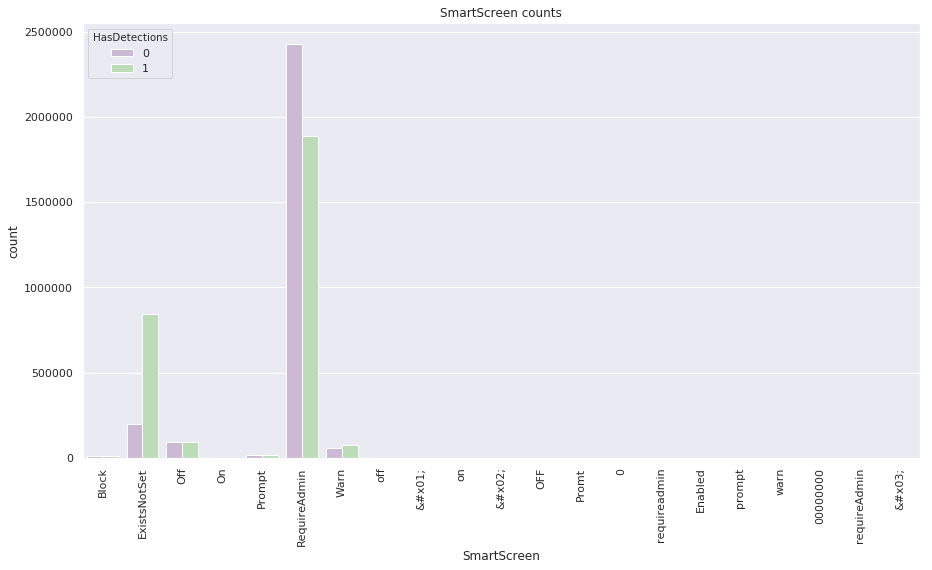

In [90]:
sns.set(rc={'figure.figsize':(15, 8)})
sns.countplot(x="SmartScreen", hue="HasDetections",  palette="PRGn", data=train)
plt.title("SmartScreen counts")
plt.xticks(rotation='vertical')
plt.show()

### Census_MDC2FormFactor

In [91]:
train['Census_MDC2FormFactor'].value_counts(dropna=False, normalize=True).cumsum()

Notebook        0.641521
Desktop         0.860216
Convertible     0.905655
Detachable      0.939083
AllInOne        0.971822
PCOther         0.987509
LargeTablet     0.995033
SmallTablet     0.998552
SmallServer     0.999519
MediumServer    0.999898
LargeServer     0.999997
ServerOther     1.000000
IoTOther        1.000000
Name: Census_MDC2FormFactor, dtype: float64

In [92]:
# top_cats = list(train['Census_MDC2FormFactor'].value_counts().index[:5])
# train.loc[train['Census_MDC2FormFactor'].isin(top_cats) == False, 'Census_MDC2FormFactor'] = 'PCOther'
# test.loc[test['Census_MDC2FormFactor'].isin(top_cats) == False, 'Census_MDC2FormFactor'] = 'PCOther'

# train['Census_MDC2FormFactor'] = train['Census_MDC2FormFactor'].cat.remove_unused_categories()
# test['Census_MDC2FormFactor'] = test['Census_MDC2FormFactor'].cat.remove_unused_categories()

In [93]:
plot_categorical_feature('Census_MDC2FormFactor', True)

Census_MDC2FormFactor has 13 unique values and type: category.
Notebook       0.641521
Desktop        0.218695
Convertible    0.045438
Detachable     0.033429
AllInOne       0.032739
Name: Census_MDC2FormFactor, dtype: float64


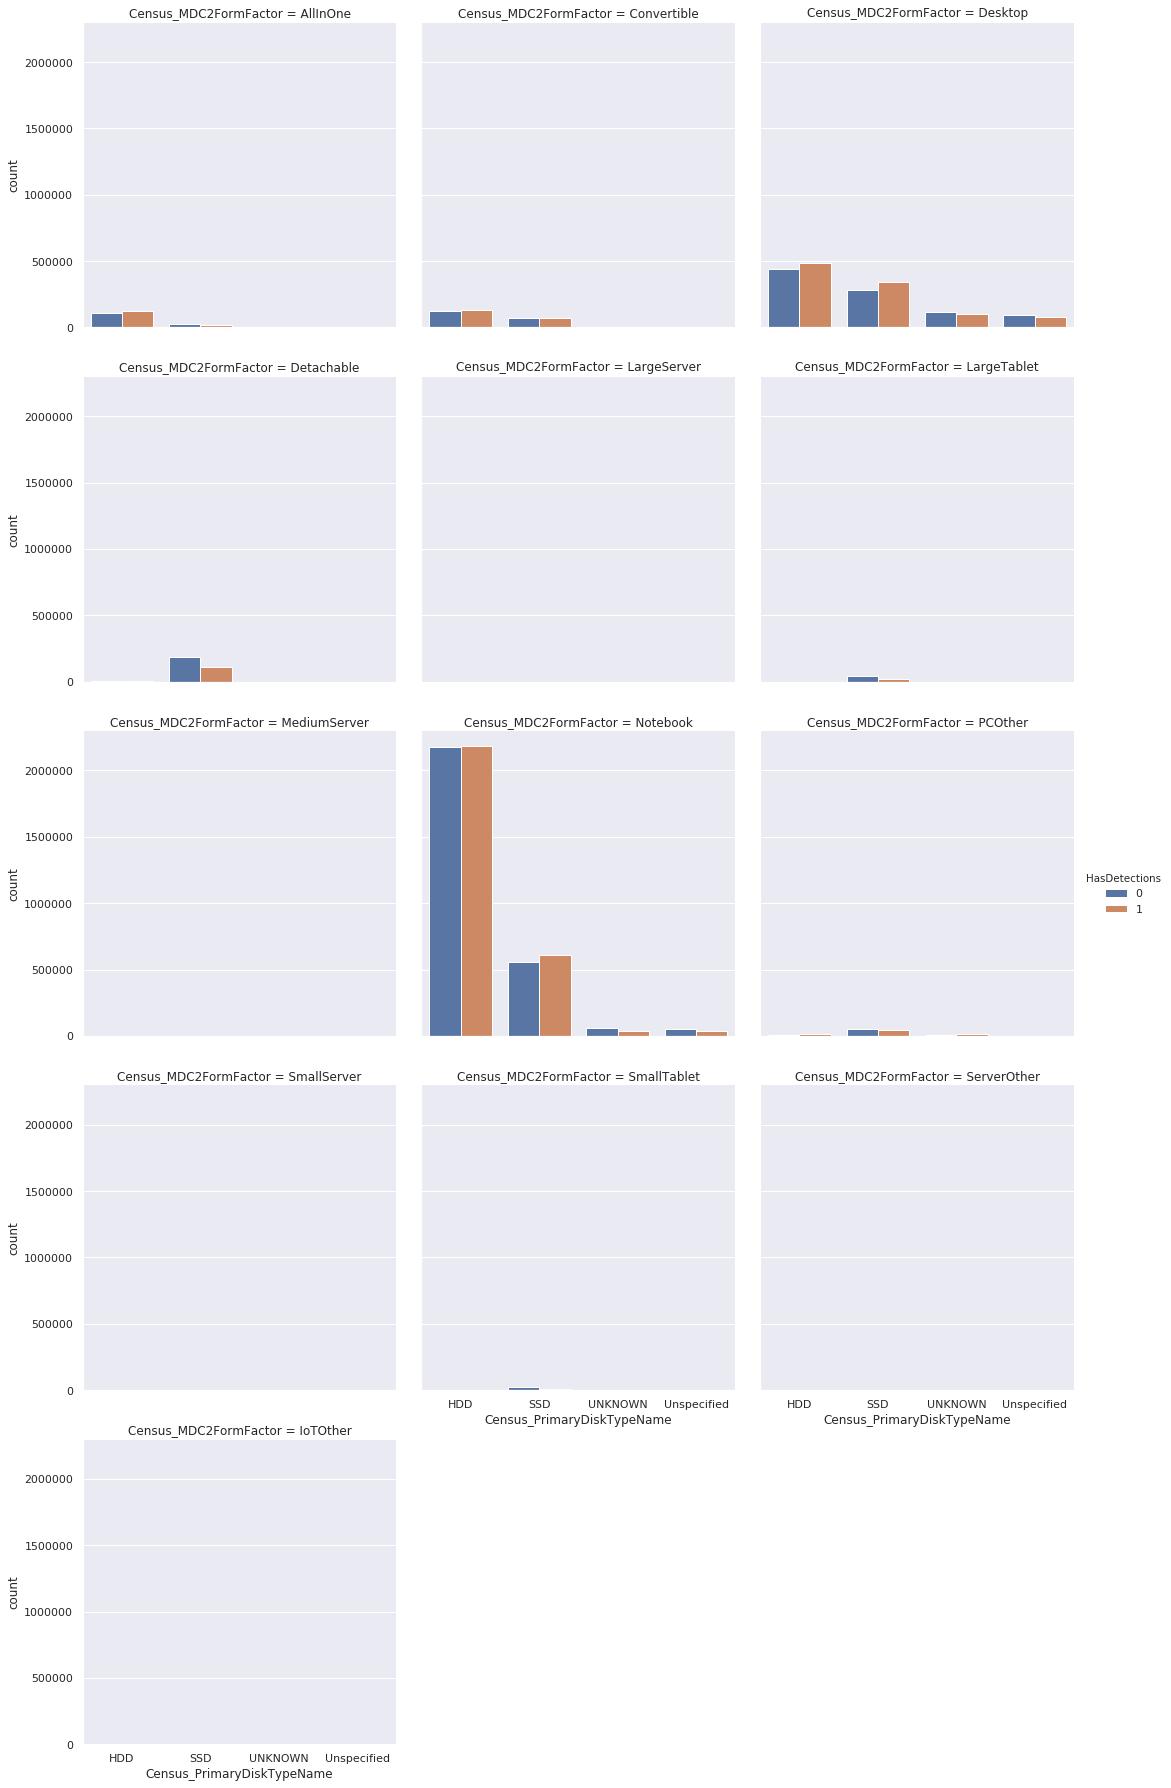

In [94]:
sns.catplot(x="Census_PrimaryDiskTypeName", hue="HasDetections", col="Census_MDC2FormFactor",
                data=train, kind="count",col_wrap=3);

It is nice to see that these two variables interact reasonably.
Detachable devices usually have SSD, desktop PC have HDD and SDD and Notebooks usually have HDD.

In [95]:
train['Census_PrimaryDiskTypeName'].value_counts(dropna=False, normalize=True).cumsum()

HDD            0.650879
SSD            0.927381
UNKNOWN        0.967537
Unspecified    0.998560
NaN            1.000000
Name: Census_PrimaryDiskTypeName, dtype: float64

In [96]:
# train.loc[train['Census_PrimaryDiskTypeName'].isin(['HDD', 'SSD']) == False, 'Census_PrimaryDiskTypeName'] = 'UNKNOWN'
# test.loc[test['Census_PrimaryDiskTypeName'].isin(['HDD', 'SSD']) == False, 'Census_PrimaryDiskTypeName'] = 'UNKNOWN'

# train['Census_PrimaryDiskTypeName'] = train['Census_PrimaryDiskTypeName'].cat.remove_unused_categories()
# test['Census_PrimaryDiskTypeName'] = test['Census_PrimaryDiskTypeName'].cat.remove_unused_categories()

### Census_ProcessorManufacturerIdentifier

In [97]:
train['Census_ProcessorManufacturerIdentifier'].value_counts(dropna=False, normalize=True).cumsum()

 5.0     0.878701
 1.0     0.995306
NaN      0.999937
 10.0    0.999975
 3.0     1.000000
 9.0     1.000000
 7.0     1.000000
 4.0     1.000000
Name: Census_ProcessorManufacturerIdentifier, dtype: float64

In [98]:
# train.loc[train['Census_ProcessorManufacturerIdentifier'].isin([5.0, 1.0]) == False, 'Census_ProcessorManufacturerIdentifier'] = 0.0
# test.loc[test['Census_ProcessorManufacturerIdentifier'].isin([5.0, 1.0]) == False, 'Census_ProcessorManufacturerIdentifier'] = 0.0

# train['Census_ProcessorManufacturerIdentifier'] = train['Census_ProcessorManufacturerIdentifier'].astype('category')
# test['Census_ProcessorManufacturerIdentifier'] = test['Census_ProcessorManufacturerIdentifier'].astype('category')

In [99]:
plot_categorical_feature('Census_ProcessorManufacturerIdentifier', True)

Census_ProcessorManufacturerIdentifier has 7 unique values and type: float16.
 5.0     0.878701
 1.0     0.116605
NaN      0.004631
 10.0    0.000038
 3.0     0.000024
Name: Census_ProcessorManufacturerIdentifier, dtype: float64


Once again anonymized variable.

### Census_PowerPlatformRoleName

In [100]:
train['Census_PowerPlatformRoleName'].value_counts(dropna=False, normalize=True).cumsum()

Mobile               0.693036
Desktop              0.924681
Slate                0.979889
Workstation          0.992183
SOHOServer           0.996425
UNKNOWN              0.998737
EnterpriseServer     0.999532
AppliancePC          0.999982
PerformanceServer    0.999993
NaN                  0.999999
Unspecified          1.000000
Name: Census_PowerPlatformRoleName, dtype: float64

In [101]:
# train.loc[train['Census_PowerPlatformRoleName'].isin(['Mobile', 'Desktop', 'Slate']) == False, 'Census_PowerPlatformRoleName'] = 'UNKNOWN'
# test.loc[test['Census_PowerPlatformRoleName'].isin(['Mobile', 'Desktop', 'Slate']) == False, 'Census_PowerPlatformRoleName'] = 'UNKNOWN'

# train['Census_PowerPlatformRoleName'] = train['Census_PowerPlatformRoleName'].cat.remove_unused_categories()
# test['Census_PowerPlatformRoleName'] = test['Census_PowerPlatformRoleName'].cat.remove_unused_categories()

In [102]:
plot_categorical_feature('Census_PowerPlatformRoleName', True)

Census_PowerPlatformRoleName has 10 unique values and type: category.
Mobile         0.693036
Desktop        0.231645
Slate          0.055208
Workstation    0.012294
SOHOServer     0.004242
Name: Census_PowerPlatformRoleName, dtype: float64


For some reason slates have quite a low rate of detections. Maybe no hackers are interested in them? :)

### Census_OSInstallTypeName

In [103]:
plot_categorical_feature('Census_OSInstallTypeName', True)

Census_OSInstallTypeName has 9 unique values and type: category.
UUPUpgrade    0.292332
IBSClean      0.185029
Update        0.178592
Upgrade       0.140286
Other         0.094168
Name: Census_OSInstallTypeName, dtype: float64


In [104]:
# top_cats = list(train['Census_OSWUAutoUpdateOptionsName'].value_counts().index[:3])
# train.loc[train['Census_OSWUAutoUpdateOptionsName'].isin(top_cats) == False, 'Census_OSWUAutoUpdateOptionsName'] = 'Off'
# test.loc[test['Census_OSWUAutoUpdateOptionsName'].isin(top_cats) == False, 'Census_OSWUAutoUpdateOptionsName'] = 'Off'

# train['Census_OSWUAutoUpdateOptionsName'] = train['Census_OSWUAutoUpdateOptionsName'].cat.remove_unused_categories()
# test['Census_OSWUAutoUpdateOptionsName'] = test['Census_OSWUAutoUpdateOptionsName'].cat.remove_unused_categories()

In [105]:
# train.loc[train['Census_GenuineStateName'] == 'UNKNOWN', 'Census_GenuineStateName'] = 'OFFLINE'
# test.loc[test['Census_GenuineStateName'] == 'UNKNOWN', 'Census_GenuineStateName'] = 'OFFLINE'

# train['Census_GenuineStateName'] = train['Census_GenuineStateName'].cat.remove_unused_categories()
# test['Census_GenuineStateName'] = test['Census_GenuineStateName'].cat.remove_unused_categories()

In [106]:
# train.loc[train['Census_ActivationChannel'].isin(['Retail', 'OEM:DM']) == False, 'Census_ActivationChannel'] = 'Volume:GVLK'
# test.loc[test['Census_ActivationChannel'].isin(['Retail', 'OEM:DM']) == False, 'Census_ActivationChannel'] = 'Volume:GVLK'

# train['Census_ActivationChannel'] = train['Census_ActivationChannel'].cat.remove_unused_categories()
# test['Census_ActivationChannel'] = test['Census_ActivationChannel'].cat.remove_unused_categories()

## Feature engineering and transformation

In [107]:
train.head()

,MachineIdentifier,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,1.1.15100.1,4.18.1807.18075,1.273.1735.0,53447.0,1.0,29,128035.0,18.0,35.0,-85,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,NaN,Desktop,2668.0,9124.0,4.0,5.0,2340.0,476940.0,HDD,299451.0,4096.0,Desktop,18.906250,1440.0,900.0,Desktop,0,4.294967e+09,10.0.17134.165,rs4_release,17134,165,pro,pro,UUPUpgrade,26.0,119,UNKNOWN,IS_GENUINE,Retail,NaN,NaN,628.0,36144.0,0,NaN,0,0.0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,1.1.14600.4,4.13.17134.1,1.263.48.0,53447.0,1.0,93,1482.0,18.0,119.0,64,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,NaN,Notebook,2668.0,91656.0,4.0,5.0,2404.0,476940.0,HDD,102385.0,4096.0,Notebook,13.898438,1366.0,768.0,Mobile,0,1.000000e+00,10.0.17134.1,rs4_release,17134,1,pro,pro,IBSClean,8.0,31,UNKNOWN,OFFLINE,Retail,NaN,NaN,628.0,57858.0,0,NaN,0,0.0,8.0,0
2,000007905a28d863f6d0d597892cd692,1.1.15100.1,4.18.1807.18075,1.273.1341.0,53447.0,1.0,86,153579.0,18.0,64.0,49,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,137.0,RequireAdmin,Desktop,4908.0,317701.0,4.0,5.0,1972.0,114473.0,SSD,113907.0,4096.0,Desktop,21.500000,1920.0,1080.0,Desktop,0,4.294967e+09,10.0.17134.165,rs4_release,17134,165,Core,Core,UUPUpgrade,7.0,30,FullAuto,IS_GENUINE,OEM:NONSLP,NaN,NaN,142.0,52682.0,0,NaN,0,0.0,3.0,0
3,00000b11598a75ea8ba1beea8459149f,1.1.15100.1,4.18.1807.18075,1.273.1527.0,53447.0,1.0,88,20710.0,NaN,117.0,115,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,ExistsNotSet,Desktop,1443.0,275890.0,4.0,5.0,2272.0,238475.0,UNKNOWN,227116.0,4096.0,MiniTower,18.500000,1366.0,768.0,Desktop,0,4.294967e+09,10.0.17134.228,rs4_release,17134,228,pro,pro,UUPUpgrade,17.0,64,FullAuto,IS_GENUINE,OEM:NONSLP,NaN,NaN,355.0,20050.0,0,NaN,0,0.0,3.0,1
4,000014a5f00daa18e76b81417eeb99fc,1.1.15100.1,4.18.1807.18075,1.273.1379.0,53447.0,1.0,18,37376.0,NaN,277.0,75,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,137.0,RequireAdmin,Notebook,1443.0,331929.0,4.0,5.0,2500.0,476940.0,HDD,101900.0,6144.0,Portable,14.000000,1366.0,768.0,Mobile,1,0.000000e+00,10.0.17134.191,rs4_release,17134,191,Core,Core,Update,8.0,31,FullAuto,IS_GENUINE,Retail,0.0,0.0,355.0,19844.0,0,0.0,0,0.0,1.0,1


In [108]:
train['OsBuildLab'] = train['OsBuildLab'].cat.add_categories(['0.0.0.0.0-0'])
train['OsBuildLab'] = train['OsBuildLab'].fillna('0.0.0.0.0-0')
test['OsBuildLab'] = test['OsBuildLab'].cat.add_categories(['0.0.0.0.0-0'])
test['OsBuildLab'] = test['OsBuildLab'].fillna('0.0.0.0.0-0')

In [109]:
def fe(df):
    df['EngineVersion_2'] = df['EngineVersion'].apply(lambda x: x.split('.')[2]).astype('category')
    df['EngineVersion_3'] = df['EngineVersion'].apply(lambda x: x.split('.')[3]).astype('category')

    df['AppVersion_1'] = df['AppVersion'].apply(lambda x: x.split('.')[1]).astype('category')
    df['AppVersion_2'] = df['AppVersion'].apply(lambda x: x.split('.')[2]).astype('category')
    df['AppVersion_3'] = df['AppVersion'].apply(lambda x: x.split('.')[3]).astype('category')

    df['AvSigVersion_0'] = df['AvSigVersion'].apply(lambda x: x.split('.')[0]).astype('category')
    df['AvSigVersion_1'] = df['AvSigVersion'].apply(lambda x: x.split('.')[1]).astype('category')
    df['AvSigVersion_2'] = df['AvSigVersion'].apply(lambda x: x.split('.')[2]).astype('category')

    df['OsBuildLab_0'] = df['OsBuildLab'].apply(lambda x: x.split('.')[0]).astype('category')
    df['OsBuildLab_1'] = df['OsBuildLab'].apply(lambda x: x.split('.')[1]).astype('category')
    df['OsBuildLab_2'] = df['OsBuildLab'].apply(lambda x: x.split('.')[2]).astype('category')
    df['OsBuildLab_3'] = df['OsBuildLab'].apply(lambda x: x.split('.')[3]).astype('category')
    # df['OsBuildLab_40'] = df['OsBuildLab'].apply(lambda x: x.split('.')[-1].split('-')[0]).astype('category')
    # df['OsBuildLab_41'] = df['OsBuildLab'].apply(lambda x: x.split('.')[-1].split('-')[1]).astype('category')

    df['Census_OSVersion_0'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[0]).astype('category')
    df['Census_OSVersion_1'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[1]).astype('category')
    df['Census_OSVersion_2'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[2]).astype('category')
    df['Census_OSVersion_3'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[3]).astype('category')

    # https://www.kaggle.com/adityaecdrid/simple-feature-engineering-xd
    df['primary_drive_c_ratio'] = df['Census_SystemVolumeTotalCapacity']/ df['Census_PrimaryDiskTotalCapacity']
    df['non_primary_drive_MB'] = df['Census_PrimaryDiskTotalCapacity'] - df['Census_SystemVolumeTotalCapacity']

    df['aspect_ratio'] = df['Census_InternalPrimaryDisplayResolutionHorizontal']/ df['Census_InternalPrimaryDisplayResolutionVertical']

    df['monitor_dims'] = df['Census_InternalPrimaryDisplayResolutionHorizontal'].astype(str) + '*' + df['Census_InternalPrimaryDisplayResolutionVertical'].astype('str')
    df['monitor_dims'] = df['monitor_dims'].astype('category')

    df['dpi'] = ((df['Census_InternalPrimaryDisplayResolutionHorizontal']**2 + df['Census_InternalPrimaryDisplayResolutionVertical']**2)**.5)/(df['Census_InternalPrimaryDiagonalDisplaySizeInInches'])

    df['dpi_square'] = df['dpi'] ** 2

    df['MegaPixels'] = (df['Census_InternalPrimaryDisplayResolutionHorizontal'] * df['Census_InternalPrimaryDisplayResolutionVertical'])/1e6

    df['Screen_Area'] = (df['aspect_ratio']* (df['Census_InternalPrimaryDiagonalDisplaySizeInInches']**2))/(df['aspect_ratio']**2 + 1)

    df['ram_per_processor'] = df['Census_TotalPhysicalRAM']/ df['Census_ProcessorCoreCount']

    df['new_num_0'] = df['Census_InternalPrimaryDiagonalDisplaySizeInInches'] / df['Census_ProcessorCoreCount']

    df['new_num_1'] = df['Census_ProcessorCoreCount'] * df['Census_InternalPrimaryDiagonalDisplaySizeInInches']
    
    df['Census_IsFlightingInternal'] = df['Census_IsFlightingInternal'].fillna(1)
    df['Census_ThresholdOptIn'] = df['Census_ThresholdOptIn'].fillna(1)
    df['Census_IsWIMBootEnabled'] = df['Census_IsWIMBootEnabled'].fillna(1)
    df['Wdft_IsGamer'] = df['Wdft_IsGamer'].fillna(0)
    
    return df

In [110]:
train = fe(train)
test = fe(test)

In [111]:
cat_cols = [col for col in train.columns if col not in ['MachineIdentifier', 'Census_SystemVolumeTotalCapacity', 'HasDetections'] and str(train[col].dtype) == 'category']
len(cat_cols)

57

In [112]:
more_cat_cols = []
add_cat_feats = [
 'Census_OSBuildRevision',
 'OsBuildLab',
 'SmartScreen',
'AVProductsInstalled']
for col1 in add_cat_feats:
    for col2 in add_cat_feats:
        if col1 != col2:
            train[col1 + '__' + col2] = train[col1].astype(str) + train[col2].astype(str)
            train[col1 + '__' + col2] = train[col1 + '__' + col2].astype('category')
            
            test[col1 + '__' + col2] = test[col1].astype(str) + test[col2].astype(str)
            test[col1 + '__' + col2] = test[col1 + '__' + col2].astype('category')
            more_cat_cols.append(col1 + '__' + col2)
            
cat_cols = cat_cols + more_cat_cols

In [113]:
to_encode = []
for col in cat_cols:
    if train[col].nunique() > 1000:
        print(col, train[col].nunique())
        to_encode.append(col)

AvSigVersion 8531
AVProductStatesIdentifier 28970
CityIdentifier 107366
Census_OEMNameIdentifier 2564
Census_OEMModelIdentifier 175365
Census_ProcessorModelIdentifier 2583
Census_InternalBatteryNumberOfCharges 41087
Census_FirmwareVersionIdentifier 50494
AvSigVersion_2 2766
monitor_dims 10061
Census_OSBuildRevision__OsBuildLab 15367
Census_OSBuildRevision__SmartScreen 1763
Census_OSBuildRevision__AVProductsInstalled 1169
OsBuildLab__Census_OSBuildRevision 15367
OsBuildLab__SmartScreen 2307
OsBuildLab__AVProductsInstalled 1951
SmartScreen__Census_OSBuildRevision 1763
SmartScreen__OsBuildLab 2307
AVProductsInstalled__Census_OSBuildRevision 1169
AVProductsInstalled__OsBuildLab 1951


### Frequency encoding

From this kernel:  https://www.kaggle.com/fabiendaniel/detecting-malwares-with-lgbm

I do frequency and label encoding on the full train dataset, because I think I'll get more correct values this way.

In [114]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)
gc.collect()

Mem. usage decreased to 2771.65 Mb (-4.2% reduction)
Mem. usage decreased to 2471.73 Mb (-4.1% reduction)


50565

In [115]:
def frequency_encoding(variable):
    t = pd.concat([train[variable], test[variable]]).value_counts().reset_index()
    t = t.reset_index()
    t.loc[t[variable] == 1, 'level_0'] = np.nan
    t.set_index('index', inplace=True)
    max_label = t['level_0'].max() + 1
    t.fillna(max_label, inplace=True)
    return t.to_dict()['level_0']

In [116]:
for col in tqdm_notebook(to_encode):
    freq_enc_dict = frequency_encoding(col)
    train[col] = train[col].map(lambda x: freq_enc_dict.get(x, np.nan))
    test[col] = test[col].map(lambda x: freq_enc_dict.get(x, np.nan))
    cat_cols.remove(col)

### Label Encoding

In [117]:
%%time
indexer = {}
for col in cat_cols:
    # print(col)
    _, indexer[col] = pd.factorize(train[col].astype(str), sort=True)
    
for col in tqdm_notebook(cat_cols):
    # print(col)
    train[col] = indexer[col].get_indexer(train[col].astype(str))
    test[col] = indexer[col].get_indexer(test[col].astype(str))
    
    train = reduce_mem_usage(train, verbose=False)
    test = reduce_mem_usage(test, verbose=False)


CPU times: user 28min 14s, sys: 1min 7s, total: 29min 22s
Wall time: 29min 21s


In [118]:
del indexer

In [119]:
train.head()

,MachineIdentifier,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,EngineVersion_2,EngineVersion_3,AppVersion_1,AppVersion_2,AppVersion_3,AvSigVersion_0,AvSigVersion_1,AvSigVersion_2,OsBuildLab_0,OsBuildLab_1,OsBuildLab_2,OsBuildLab_3,Census_OSVersion_0,Census_OSVersion_1,Census_OSVersion_2,Census_OSVersion_3,primary_drive_c_ratio,non_primary_drive_MB,aspect_ratio,monitor_dims,dpi,dpi_square,MegaPixels,Screen_Area,ram_per_processor,new_num_0,new_num_1,Census_OSBuildRevision__OsBuildLab,Census_OSBuildRevision__SmartScreen,Census_OSBuildRevision__AVProductsInstalled,OsBuildLab__Census_OSBuildRevision,OsBuildLab__SmartScreen,OsBuildLab__AVProductsInstalled,SmartScreen__Census_OSBuildRevision,SmartScreen__OsBuildLab,SmartScreen__AVProductsInstalled,AVProductsInstalled__Census_OSBuildRevision,AVProductsInstalled__OsBuildLab,AVProductsInstalled__SmartScreen
0,0000028988387b115f69f31a3bf04f09,65,59,134.0,0.0,1,144,205.0,8,223,111,6,3,4,273,6,24,15,2,0.0,22022.0,4.0,5.0,135.0,476940.0,0,299451.0,4096.0,24,18.906250,1440.0,900.0,1,0,1.0,361,10,96,75,6,5,6,18,17,5,1,2,1.0,1.0,448,2572.0,0,1.0,0,0.0,1,0,59,1,8,25,54,1,48,211.0,19,1,1,14,0,0,96,75,0.627930,177489.0,1.599609,6.0,inf,inf,inf,160.7500,1024.0,4.726562,75.62500,3.0,8.0,3.0,3.0,0.0,0.0,8.0,0.0,61,3.0,0.0,16
1,000007535c3f730efa9ea0b7ef1bd645,55,26,0.0,0.0,1,215,171.0,8,22,213,6,3,4,273,6,24,15,8,0.0,118655.0,4.0,5.0,134.0,476940.0,0,102385.0,4096.0,38,13.898438,1366.0,768.0,3,0,2.0,357,10,96,1,6,5,2,37,79,5,2,2,1.0,1.0,448,1415.0,0,1.0,0,0.0,13,0,54,4,3,6,1,1,43,0.0,19,1,1,14,0,0,96,1,0.214722,374555.0,1.778320,0.0,inf,inf,inf,82.5000,1024.0,3.474609,55.59375,19.0,17.0,19.0,19.0,0.0,0.0,17.0,0.0,61,19.0,0.0,16
2,000007905a28d863f6d0d597892cd692,65,59,336.0,0.0,1,207,673.0,8,254,197,6,12,4,273,4,24,13,2,10.0,2.0,4.0,5.0,191.0,114473.0,1,113907.0,4096.0,24,21.500000,1920.0,1080.0,1,0,1.0,361,10,96,75,1,1,6,36,78,2,1,1,1.0,1.0,89,184.0,0,1.0,0,0.0,8,0,59,1,8,25,54,1,48,295.0,19,1,1,14,0,0,96,75,0.995117,566.0,1.777344,1.0,inf,inf,inf,197.6250,1024.0,5.375000,86.00000,3.0,7.0,3.0,3.0,1.0,0.0,7.0,1.0,47,3.0,0.0,14
3,00000b11598a75ea8ba1beea8459149f,65,59,25.0,0.0,1,209,20.0,49,20,145,6,3,4,273,6,24,7,2,2.0,158.0,4.0,5.0,63.0,238475.0,2,227116.0,4096.0,36,18.500000,1366.0,768.0,1,0,1.0,365,10,96,161,6,5,6,8,112,2,1,1,1.0,1.0,240,30.0,0,1.0,0,0.0,8,1,59,1,8,25,54,1,48,23.0,19,1,1,14,0,0,96,161,0.952148,11359.0,1.778320,0.0,inf,inf,inf,146.1250,1024.0,4.625000,74.00000,0.0,22.0,0.0,0.0,6.0,0.0,22.0,6.0,19,0.0,0.0,8
4,000014a5f00daa18e76b81417eeb99fc,65,59,18.0,0.0,1,89,13.0,49,195,225,6,12,4,273,4,24,13,8,2.0,2269.0,4.0,5.0,52.0,476940.0,0,101900.0,6144.0,41,14.000000,1366.0,768.0,3,1,0.0,363,10,96,136,1,1,7,37,

## Idea of training on all data
Let's try training model on three subsets of train data separately and blend the predictions.

In [120]:
y = train['HasDetections']
train = train.drop(['HasDetections', 'MachineIdentifier'], axis=1)
test = test.drop(['MachineIdentifier'], axis=1)
gc.collect()
train.sort_values('AvSigVersion')
train1 = train[:4000000]
train = train[4000000:8000000]

y1 = y[:4000000]
y = y[4000000:8000000]

### Modelling

Added possibility to do rank averaging.

In [121]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=15)
# folds = TimeSeriesSplit(n_splits=5)

In [122]:
from numba import jit
# fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
@jit
def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

def eval_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'auc', fast_auc(labels, preds), True

# idea from this kernel: https://www.kaggle.com/fabiendaniel/detecting-malwares-with-lgbm
def predict_chunk(model, test):
    initial_idx = 0
    chunk_size = 1000000
    current_pred = np.zeros(len(test))
    while initial_idx < test.shape[0]:
        final_idx = min(initial_idx + chunk_size, test.shape[0])
        idx = range(initial_idx, final_idx)
        current_pred[idx] = model.predict(test.iloc[idx], num_iteration=model.best_iteration)
        initial_idx = final_idx
    #predictions += current_pred / min(folds.n_splits, max_iter)
    return current_pred


def train_model(X=train, X_test=test, y=y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, averaging='usual', make_oof=False):
    result_dict = {}
    if make_oof:
        oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        gc.collect()
        print('Fold', fold_n + 1, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train, categorical_feature = cat_cols)
            valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature = cat_cols)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=2000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200,
                    feval=eval_auc)

            del train_data, valid_data
            
            y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
            del X_valid
            gc.collect()
            # print('predicting on test')
            # y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            y_pred = predict_chunk(model, X_test)
            # print('predicted')
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            #y_pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
            y_pred = predict_chunk(model, xgb.DMatrix(X_test))
            
        if model_type == 'lcv':
            model = LogisticRegressionCV(scoring='roc_auc', cv=3)
            model.fit(X_train, y_train)

            y_pred_valid = model.predict(X_valid)
            # y_pred = model.predict(X_test)
            y_pred = predict_chunk(model, X_test)
            
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            # y_pred = model.predict(X_test)
            y_pred = predict_chunk(model, X_test)
        
        if make_oof:
            oof[valid_index] = y_pred_valid.reshape(-1,)
            
        scores.append(fast_auc(y_valid, y_pred_valid))
        print('Fold roc_auc:', roc_auc_score(y_valid, y_pred_valid))
        print('')
        
        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        
        if plot_feature_importance:
            feature_importance["importance"] /= n_fold
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
            logging.info('Top features')
            for f in best_features.sort_values(by="importance", ascending=False)['feature'].values:
                logging.info(f)

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            
    result_dict['prediction'] = prediction
    if make_oof:
        result_dict['oof'] = oof
    
    return result_dict

In [123]:
# params from https://www.kaggle.com/fabiendaniel/detecting-malwares-with-lgbm
params = {'num_leaves': 256,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 5,
         'learning_rate': 0.05,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 5,
         "bagging_fraction": 0.8,
         "bagging_seed": 11,
         "lambda_l1": 0.15,
         "lambda_l2": 0.15,
         "random_state": 42,          
         "verbosity": -1}

In [124]:
del stats_df, freq_enc_dict

Fold 1 started at Mon Feb 25 17:22:37 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.60604	training's auc: 0.727995	valid_1's binary_logloss: 0.611563	valid_1's auc: 0.719901
[1000]	training's binary_logloss: 0.599621	training's auc: 0.736543	valid_1's binary_logloss: 0.608923	valid_1's auc: 0.723367
[1500]	training's binary_logloss: 0.596142	training's auc: 0.74117	valid_1's binary_logloss: 0.608325	valid_1's auc: 0.724134
[2000]	training's binary_logloss: 0.593576	training's auc: 0.744533	valid_1's binary_logloss: 0.608203	valid_1's auc: 0.72429
Did not meet early stopping. Best iteration is:
[2000]	training's binary_logloss: 0.593576	training's auc: 0.744533	valid_1's binary_logloss: 0.608203	valid_1's auc: 0.72429
Fold roc_auc: 0.72429007246075

Fold 2 started at Mon Feb 25 18:25:21 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.606026	training's auc: 0.728014	valid_1's b

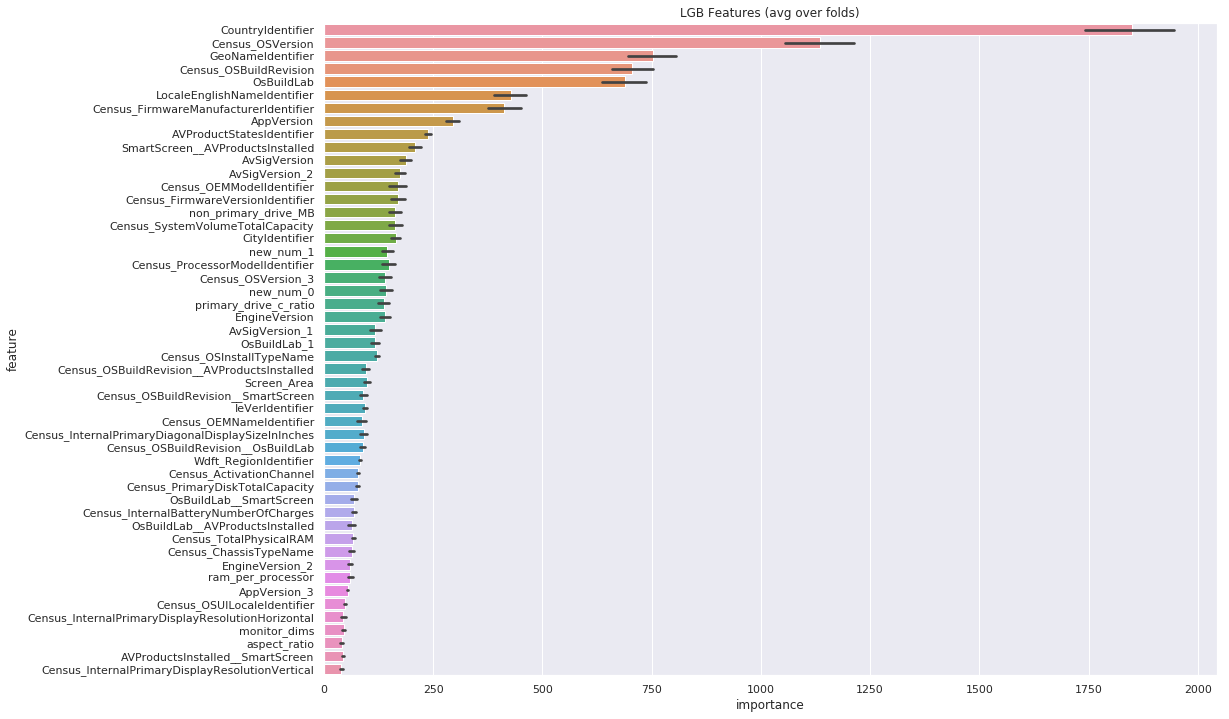

In [125]:
result_dict1 = train_model(X=train1, X_test=test, y=y1, params=params, model_type='lgb', plot_feature_importance=True, averaging='rank')

In [126]:
del train1, y1

In [127]:
# params = {'num_leaves': 64,
#          'min_data_in_leaf': 20,
#          'objective': 'binary',
#          'max_depth': 5,
#          'learning_rate': 0.05,
#          "boosting": "gbdt",
#          "feature_fraction": 0.9,
#          "bagging_freq": 5,
#          "bagging_fraction": 0.7,
#          "bagging_seed": 11,
#          "lambda_l1": 0.2,
#          "lambda_l2": 0.2,
#          "random_state": 13,          
#          "verbosity": -1}
# result_dict = train_model(X=train, X_test=test, y=y, params=params, model_type='lgb', plot_feature_importance=False, averaging='rank')

In [128]:
submission = pd.read_csv('../input/sample_submission.csv')

# submission['HasDetections'] = (result_dict['prediction'] + result_dict1['prediction'] + result_dict2['prediction']) / 3
# submission['HasDetections'] = (result_dict['prediction'] + result_dict1['prediction']) / 2
submission['HasDetections'] = result_dict1['prediction']
submission.to_csv('lgb_rank.csv', index=False)